# Machine Learning Demonstrations

In this notebook, we showcase how to use kdb+/q to carry out a number of machine learning tasks. Below we show how use statistical techniques and feature engineering in conjunction with machine learning models can be used to predict the future behaviour of a number of time series datasets.

<div class="alert alert-danger">
To run the below notebook, ensure that dependencies specified in the <a href="https://github.com/kxsystems/ml">machine learning toolkit</a>  <b>requirements.txt</b> file have been correctly installed.
</div>

## Machine Learning Toolkit

The ML-Toolkit contains the following,

* General use utilities for model scoring and preprocessing
* An implementation of the FRESH (Feature Extraction based on Scalable Hypothesis tests) algorithm
* Cross validation and grid search functionality 
* Native implementations of clustering algorithms
* Workflow generation tools 
* Time series models

The primary purpose of these libraries are to provide both novice and seasoned kdb+/q users with access to commonly-used ML functions and frameworks for preprocessing data, extracting features, building models and analyzing results.

The toolkit is used throughout this notebook and can be loaded using the below syntax assuming the toolkit has been located in a users `$QHOME`/`%QHOME%`.

In [1]:
\l ml/ml.q
.ml.loadfile`:init.q

\l ../utils/util.q
\l ../utils/graphics.q

## Time Series Forecasting

In time series analysis, time series forecasting is the use of a model to predict the future values of a dataset based on historical observations. Forecasting can be achieved using a wide range of techniques from statistical models and simple linear regression to complex neural network constructs. 

Use cases for time series forecasting include but are not limited to prediction of the following (ordered from the least to the most difficult)
* Household energy consumption
* Product line sales
* Weather pattern evolution 
* The price of a stock or commodity

This notebook will demonstrate a number of models, analysis techniques and feature engineering methods. These techniques are not use case specific and could be used across the examples mentioned above.

## Transport For London (TFL) bike sharing example

The use case described below is the prediction of future bike shares within the Transport For London (TFL) bike sharing network. These predictions are based on historical bike share information, weather forecasting and holiday/weekend information relating to the days being forecast.

The dataset utilised in this example has been sourced from Kaggle [here](https://www.kaggle.com/hmavrodiev/london-bike-sharing-dataset) and consolidates data from 3 different sources
1. Bike share/rental data: https://cycling.data.tfl.gov.uk
2. Weather data: https://freemeteo.com
3. Holiday information: https://www.gov.uk/bank-holidays

This data was collected over a period of 2 years from January 1st 2015 to December 31st 2016.

The  analysis techniques, statistical models and feature engineering processes demonstrated in this notebook split into 4 primary analysis sections outlined briefly as follows

1. [Data Loading and Preprocessing](#Data-Loading-and-Preprocessing):

    The following steps are completed in this section:
    * Load the dataset into memory
    * Ensure the data is equispaced and is not sparse
    * Remove any data not required for analysis (constant columns, null data indicators etc.)
    * Split the data into training and testing sets for model testing


2. [Data Exploration and Analysis](#Data-Exploration-and-Analysis):

    Complete a preliminary analysis of the dataset. The aim is to ensure data is suitable for the generation of the proposed models and provides a guide for lagged parameters and residual error values
    * Generate plots of the raw datasets over a number of time periods in an attempt to detect macroscopic trends
    * Autocorrelation analysis
    * Partial autocorrelation analysis
    * Data stationarity testing


3. [Statistical Modelling](#statistical-modelling)
    
    Apply the following statistical models to predict future bike shares 
    * AutoRegressive(AR) Model
    * AutoRegressive Moving Average(ARMA) Model
    * Seasonal AutoRegressive Integrated Moving Average(SARIMA) Model


4. [Feature Engineering and Machine Learning](#feature-engineering):
    
    Use the following feature engineering techniques in conjunction with a random forest regressor to generate a predictive model for comparison with the statistical methods above
    * Generation of lagged features
    * Generation of windowed historical features
    
**Note:**

Not all models and techniques provided in the machine learning toolkit are demonstrated in this notebook. The following functionality is **not** outlined within this demonstration

1. Fitting of an AutoRegressive Integrated Moving Average (ARIMA) model, documented [here](https://code.kx.com/ml/toolkit/timeseries/models/#autoregressive-integrated-moving-average-arima-model)

2. Fitting of an AutoRegressive Conditional Heteroskedasticity (ARCH) model, documented [here](https://code.kx.com/ml/toolkit/timeseries/models/#autoregressive-conditional-heteroskedasticity-arch-model).
3. Akaike Information Criterion (AIC) Analysis, documented [here](https://code.kx.com/ml/toolkit/timeseries/models/#mltsarimaaicparam)

---

## Data Loading and Preprocessing

### Loading TFL bike dataset

In [2]:
show 5#bikeSales:("PFFFFFFBBF";enlist ",")0:`:../data/london_merged.csv

// save the timestamp column for use in plotting
bikeTimeStamp:bikeSales`timestamp

-1"\nMetadata information summarizing the dataset.";
meta bikeSales

timestamp                     cnt t1  t2  hum  wind_speed weather_code is_hol..
-----------------------------------------------------------------------------..
2015.01.04D00:00:00.000000000 182 3   2   93   6          3            0     ..
2015.01.04D01:00:00.000000000 138 3   2.5 93   5          1            0     ..
2015.01.04D02:00:00.000000000 134 2.5 2.5 96.5 0          1            0     ..
2015.01.04D03:00:00.000000000 72  2   2   100  0          1            0     ..
2015.01.04D04:00:00.000000000 47  2   0   93   6.5        1            0     ..

Metadata information summarizing the dataset.


c           | t f a
------------| -----
timestamp   | p    
cnt         | f    
t1          | f    
t2          | f    
hum         | f    
wind_speed  | f    
weather_code| f    
is_holiday  | b    
is_weekend  | b    
season      | f    


The following outlines the underlying meaning of the columns contained within the dataset

|Column name   | Description|
|:-------------|:------------|
| timestamp    | Hour of the day the data was collected |
| cnt          | The count of the new bike shares |
| t1           | The actual temperature in Celcius |
| t2           | The 'feels like' temperature in Celcius|
| hum          | The humidity as a percentage |
| wind_speed   | Windspeed in km/h |
| weather_code | Category of the weather |
| is_holiday   | 1 holiday / 0 non-holiday |
| is_weekend   | 1 if day is on the weekend |
| season       | category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter. |


### Clean dataset prior to train-test split

In order to ensure that the data is suitable for use with the models and techniques described below, a number of preprocessing steps are completed

1. As models must be equispaced for use with the ar/arma/sarima models, missing timestamps are added to ensure the data is equispaced.
2. Missing values are added by data forward and then back filling the dataset, this is completed using `.ml.filltab` contained within the toolkit.
3. Remove any `'*_null'` columns generated in the application of `.ml.filltab` null data in this instance is incredibly sparse and does not provide information which adds to the performance of the time series models
4. Models require that only numeric values are present, therefore the timestamp column is decomposed into its constituent parts (hour, date, month etc)using `.ml.timestamp` contained within the toolkit.
5. Remove any columns containing non time varying constant data, any such data does not contain information a time series model will benefit from


In [3]:
bikeSales:.util.dateFill[`timestamp;bikeSales;01:00:00.000] / add missing hourly data to ensure equispace
bikeSales:.ml.filltab[bikeSales;();`timestamp;::]           / forward and back fill data
delcols:cb where(cb:cols bikeSales)like"*_null"             / find any null encoding columns
bikeSales:![bikeSales;();0b;delcols]                        / remove null encoding columns
bikeSales:.ml.timesplit[bikeSales;`timestamp]               / decompose timestamp to constituents
bikeSales:.ml.dropconstant bikeSales                        / remove constant columns

Future Deprecation Warning: function will no longer be callable after version '3.0'. Please use '.ml.fillTab' instead.
Future Deprecation Warning: function will no longer be callable after version '3.0'. Please use '.ml.timeSplit' instead.
Future Deprecation Warning: function will no longer be callable after version '3.0'. Please use '.ml.dropConstant' instead.


### Train-test split

When dealing with time series datasets, splitting data into training and testing sets must take into account the temporal nature of the data. This means that the training set should not contain any information from the future and the data should be ordered chronologically. This ensures that when the performance of a model is tested the results reflect the ability of the model to forecast into the future.

In the below example, the data is split such that the first 80% of the data resides in the training set, with the remaining 20% is assigned to the testing set.

When dealing with time series statistical models it is important to define endogenous and exogenous variables as they are used widely within the literature

| Type       | Definition|
|------------|:----------|
| Endogenous | The values of this variable are determined by the model i.e. form the basis for a 'target' variable to be predicted |
| Exogenous  | This is any variable whose value is determined outside of the model and which may impose an effect on the endogenous variable i.e. if there is a national holiday this may effect the endogenous variable but is completely independent of its behaviour.|

In the below train test split the exogenous variables are found within `xTrainSales` and `xTestSales`, while the endogenous time series data is found under `yTrainSales` and `yTestSales`.

In [4]:
endog:bikeSales`cnt             / retrieve endogenous variable
exog :delete cnt from bikeSales / remove endogenous variable to avoid leakage

tts:.util.ttsTimeSeries[exog;endog;0.2]

xTrainSales:tts`xtrain
yTrainSales:tts`ytrain
xTestSales:tts`xtest
yTestSales:tts`ytest

-1"There are ",string[count xTrainSales]," data points in the training set.";
-1"There are ",string[count xTestSales] ," data points in the testing set.";

There are 14035 data points in the training set.
There are 3509 data points in the testing set.


---

## Data Exploration and Analysis

Before applying a forecasting model to a time series dataset, it is important to understand the trends that are present within the data. This allows a user to choose suitable input parameters for models. In addition to this, statistical analysis techniques can also be used to highlight potential issues which may cause issues when fitting and using these models.

The following plots are displayed to show visible trends within the dataset, 
1. Changes in the number of bike shares over a period of one week.
2. Changes in the number of bike shares over a period of one month.
3. Changes in temperature over a period of one year

In addition to this a number of statistical techniques are applied with associated graphs showing the macroscopic trends within the data which may help in model design and the suitability of the target as a candidate for statistical time series modelling. These techniques are

1. The generation of a autocorrelation plot highlighting the correlation between the current data point and historical lagged points.
2. The generation of a partial autocorrelation plot which measures the degree of association between two random variables, in this case the data at point `t` and data at `t - lag`
3. The application of a stationarity test to ensure the endogenous time series being predicted is stationary i.e. mean, variance and autocorrelation do not change above a certain level over the time series.

### Data visualisations

**One week of sales**

The following graph shows the number of bike shares completed within the first week of the dataset collection.

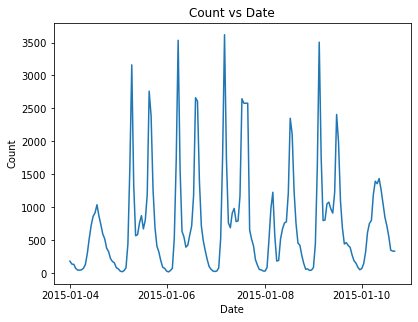

In [5]:
.util.plotTimeSeries[168#bikeTimeStamp;168#yTrainSales;"Count"]

A number of observations about the system behaviour can be garnered from this.

1. Data collected during the working week 5th to 9th January exhibits a double peak type behaviour as a resulting from daily commuters.
2. Bike shares at the weekend reach a higher mid day peak than the mid week shares but less overall use as they do not experience commuting behaviour.

**One month of sales**

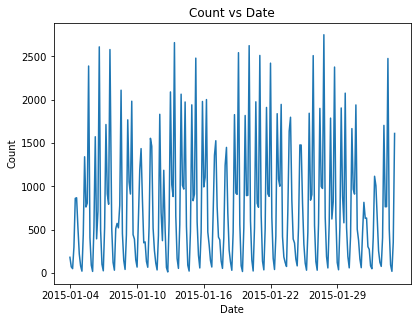

In [6]:
// indices relating to the first month of data at 3 hour increments
idx:.ml.arange[0;730;3]
.util.plotTimeSeries[bikeTimeStamp idx;yTrainSales idx;"Count"]

From the above data it can be seen that there was not a marked difference in behaviour of the system over the course of a single month

**One year of real temperature data**

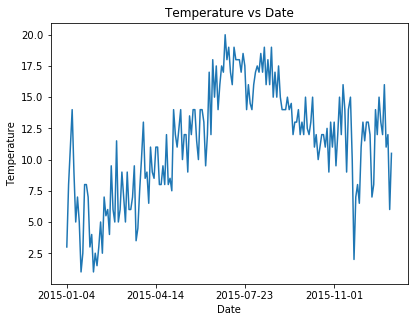

In [7]:
// indices to sample data every 48 hours over a year
idx:.ml.arange[0;8760;48]

.util.plotTimeSeries[bikeTimeStamp idx;xTrainSales[`t1]idx;"Temperature"]

The temperature in London over the course of a calendar year fluctuated between $1^oC$ and $20^oC$ during 2015. A number of 'extreme' events occuring in January and November where temperature deviated markedly from the weather during the season.

### Autocorrelation plot

Autocorrelation plots are a tool which allow users to examine randomness within a time series and to discern trends within the data which may indicate seasonal and trending behaviours. This is achieved through calculation of the correlation between a value and a historically lagged representation of that value.

The following outlines the meaning of these correlations within the the accepted range -1 and 1:

| Value | Explanation |
|-------|:------------|
|  1  | The data at point k and k-lag are perfectly positively correlated i.e. as x increases y must increase |
|  0  | No correlation exists between the data at point k and k-lag |
| -1  | The data at point k and k-lag are perfectly negatively correlated i.e. as x increases y must decrease |

Each autocorrelation plot also provides a 95% confidence interval outside of which data can be deemed to be of significance i.e. not white noise.

**8 days of data**

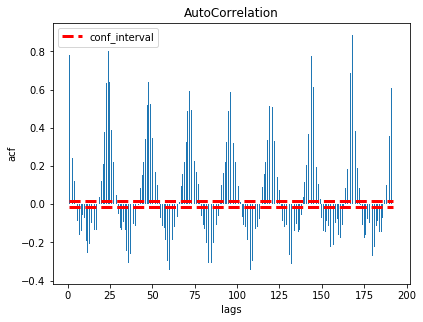

In [8]:
eightDays:1+til 192
.ml.ts.acfPlot[yTrainSales;eightDays;1]

From the above graph it is clear that the number of bike shares is correlated heavily with both the time of day and the day of the week. 

* It can be seen that there is a strong positive correlation between data points collected 24 hours apart and a negative correlation with those 12 hours lagged. This indicates a cycle that is strongly dependant on the day/night cycle.
* The highest correlation occurs at the 1 week interval. Given that data collection started on a Sunday (January 4th 2015) this indicates that bike sharing behaviour on a Sunday is likely very similar week on week.
* Data collected at the weekend and midweek is not as strongly correlated as on a week interval. As noted previously commuting behaviour and that observed during the weekend are not entirely compatible.

**One year of data**

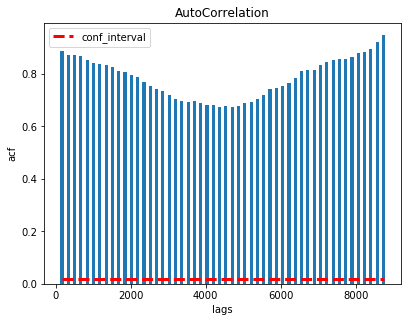

In [9]:
oneYear:.ml.arange[168;8760;168]
.ml.ts.acfPlot[yTrainSales;oneYear;168]

The above plot shows the correlation between the data points collected at the same time of day over a period of one year on a weekly basis. The following can be inferred from this analysis

1. Data collected at the same time of the week throughout the year is positively correlated.
2. There is a seasonal component to the correlation.
    * As the lags move out towards the summer (lag approximately 4300) the data is less positively correlated.
    * Returning to the winter months the data returns to a high positive correlation

The above plots indicate that both a daily, weekly and if possible yearly seasonality component should be taken into account when generating models below.

### Partial Autocorrelation

A partial autocorrelation graph provides insights into the relationship between a time series and its historical lagged values when correlations due to lagged values on shorter time scales have been removed.

Such plots can be used when attempting to identify the lag order of an autoregressive model. This can often be determined based on the lag at which the partial autocorrelation is within or near the 95% confidence bands. In this range the use of such lags can be considered as potential candidate lags for an AR model.

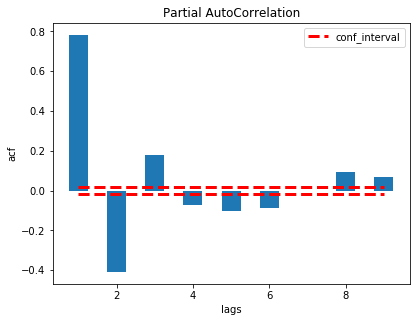

In [10]:
.ml.ts.pacfPlot[yTrainSales;10]

The above graph indicates that lags on the order 4 to 7 should be considered as appropriate lags when attempting to fit an autoregressive model.

### Stationarity

The application of time series models such as ARIMA and SARIMA models require that the features being forecast are stationary. This means that the statistical properties of the series remain constant over time namely, mean, variance, autocorrelation etc.

If a dataset is not stationary, stationarity can be achieved through the application of differencing. This entails the subtraction of a time series by a lagged version of the series.

To validate that a time series is stationary, an Augmented Dickey Fuller (ADF) test can be applied. This tests how strongly a time series is determined by a trend. The result of this test is determined by the return of the function known as the p value. If this is less than 0.05, then the time series can be considered stationary.

The following tests the stationarity of the time series being predicted:

In [11]:
.ml.ts.stationarity yTrainSales

    | ADFstat   pvalue       stationary CriticalValue_1% CriticalValue_5% Cri..
----| -----------------------------------------------------------------------..
data| -8.708512 3.644531e-14 1          -3.430817        -2.861747        -2...


As indicated by the stationary column in the above graph, the endogenous series can be deemed stationary based on the application of the Augmented Dickey Fuller test. As such, time series differencing as required by ARIMA models is not needed for this use case.

---

# Models

Throughout this demonstration, a number of models are tested to show how they can be used in the prediction of bike shares within the TFL bike sharing network. These models are

1. AutoRegressive (AR) Model
2. AutoRegressive Moving Average (ARMA) Model 
3. Seasonal AutoRegressive Integrated Moving Average (SARIMA) Model

Each of these models tackles different aspects of prediction and has their own pros and cons as applied to the use case in question.

### Analysis of results

The following analyses and reports are generated for each of the models being tested in order to ensure that any comparison of model performance is well controlled and understood.

1. Calculate the root mean squared logarithmic error (RMSLE) between the predicted and actual values for the bike shares.
2. Plot the first week of predicted values to show the short term horizon of predictions.
3. Plot the difference between the predicted and true values for the first week of predictions in order to discern how the predictions deviate away from the initial fit.

To achieve the above, the following functions are generated within utils.q

| Function             | Purpose   |
|:---------------------|:----------|
|`.util.rmsle`         | Calculate and display the RMSLE between two vectors |
|`.util.plotPredTrue`  | Plot both the predicted and true values of a forecasting series |
|`.util.plotResiduals` | Plot the residual errors as a function of forecasting series |



<a id='AR-Model'></a>
## AR Model

An AR model is a form of time series model where the output values of the model depend linearly on previous values in the series. 

The model is suitable for use cases where there is a correlation between the value being predicted and historical values within the series.

The following outlines the procedure by which an AR model can be fit on observed data and used to predict the future values of a time series using the functions `.ml.ts.AR.fit` and `.ml.ts.AR.predict`. 

**Fit an AR Model**

Based on the partial autocorrelation analysis produced above, 6 lagged values are used in generation of the AR model below.

In [12]:
numLags:6    / how many lagged terms are to be accounted for?
isTrend:1b   / is there a trend to be accounted for?

ARmdl:.ml.ts.AR.fit[yTrainSales;xTrainSales;numLags;isTrend]

ARmdl.modelInfo

coefficients| -36977.61 47.17566 -13.82186 -12.1693 -5.556304 -7.829899 5.089..
trendCoeff  | ,-36977.61
exogCoeff   | 47.17566 -13.82186 -12.1693 -5.556304 -7.829899 5.089357 9.0680..
pCoeff      | -0.12745 -0.04892891 -0.04738016 0.1316071 -0.6003736 1.009695
lagVals     | 1584 1602 1763 2492 4505 4379f


**Predicting future values using the AR model**

In [13]:
5#ARpred:ARmdl.predict[xTestSales;count yTestSales]

3202.544 2337.913 1931.225 1673.096 1332.973


**Analysis of results**

In [14]:
.util.rmsle[ARpred;yTestSales]

"The RMSLE is: 0.9345107"


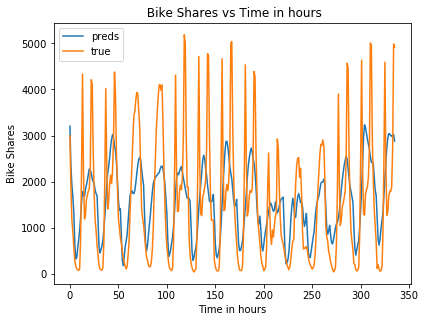

In [15]:
forthnightPred:336#ARpred;
forthnightTrue:336#yTestSales;
.util.plotPredTrue[forthnightPred;forthnightTrue]

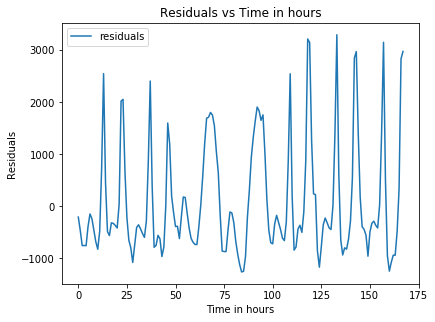

In [16]:
// 1 week of data at 1 hour intervals
idx:.ml.arange[0;168;1]
.util.plotResiduals[yTestSales idx;ARpred idx;idx]

**Summary**

* Looking at the plot of predicted and true values, it is possible to see that the predictions are following the general daily cycles defining the day and night cycles.
* The model however does not capture the weekly or daily cycles relating to the workday weekend split and the commuting behaviour of individuals in London.

To test if the addition of an moving average term to take into account previous errors and correct for them, the use of an ARMA model is tested in the following section.

## ARMA Model

An ARMA model is an extension of the AR model described above. In this case, the model suggests that a time series can be predicted not just based on the historical behaviour of the system but also by taking into account the difference between the predicted and true values of previously predicted points.

As with the AR model above, it is assumed that the dataset being predicted is stationary and thus no time series differencing needs to be accounted for. 

The following outlines the procedure by which an AR model can be fit on observed data and used to predict the future values of a time series using the functions `.ml.ts.ARMA.fit` and `.ml.ts.ARMA.predict`. 

**Fit an ARMA Model**

A total of `p=6` historical values and `q=1` historical errors are taken into account in the following model fit

In [17]:
numLags   :6   / how many lagged terms are to be accounted for?
mavgVals  :1   / number of residuals to be accounted for
isTrend   :1b  / is there a trend to be accounted for?
ARMAmdl:.ml.ts.ARMA.fit[yTrainSales;xTrainSales;numLags;mavgVals;isTrend]

ARMAmdl.modelInfo

coefficients  | -39034.18 37.96344 -10.99165 -9.75264 -4.656829 -7.409624 3.7..
trendCoeff    | -39034.18
exogCoeff     | 37.96344 -10.99165 -9.75264 -4.656829 -7.409624 3.73749 7.743..
pCoeff        | -0.0987807 -0.05153456 -0.07928611 0.272467 -0.8430701 1.241787
qCoeff        | ,-0.2399202
lagVals       | 1510 1584 1602 1763 2492 4505 4379f
residualVals  | ,-55.3207
residualCoeffs| 47.87385 -13.89946 -12.12053 -5.690197 -8.096856 3.959971 9.4..
paramDict     | `p`q`trend!(6;1;1b)


**Predicting future values using the ARMA model**

In [18]:
5#ARMApred:ARMAmdl.predict[xTestSales;count yTestSales]

3200.611 2330.177 1939.448 1677.704 1337.237


**Analysis of results**

In [19]:
.util.rmsle[ARMApred;yTestSales]

"The RMSLE is: 0.9016821"


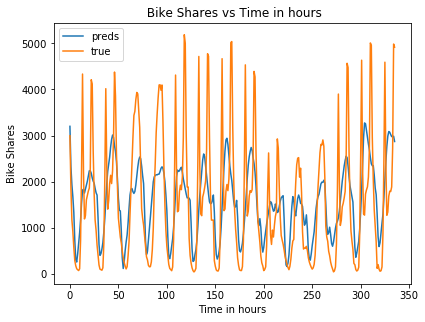

In [20]:
forthnightPred:336#ARMApred;
forthnightTrue:336#yTestSales;
.util.plotPredTrue[forthnightPred;forthnightTrue]

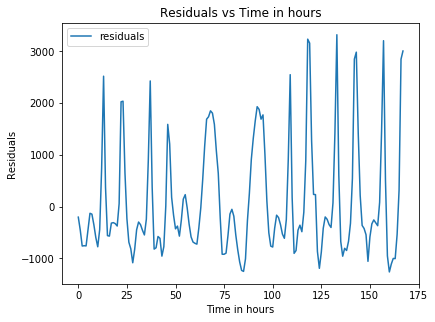

In [21]:
// 1 week of data at 1 hour intervals
idx:.ml.arange[0;168;1]
.util.plotResiduals[yTestSales idx;ARMApred idx;idx]

**Summary**

* In comparison to the calculation of the RMSLE using with the AR model, the ARMA model performs slightly better

| Model | RMSLE   |
|:------|---------|
| AR    | 0.93451 |
| ARMA  | 0.90168 |
* The model however still does not capture any seasonal (weekly or daily) components relating to the workday weekend split and the commuting behaviour of individuals in London.

Given the clear seasonal components related to the working week cycle (commuting mid week), a SARIMA model is tested in the following section.

## SARIMA Model

A SARIMA model is an extension of the ARMA model above. 

As with the ARMA model, this takes into account lagged values and past residual errors when generating the model and predictions. The integrated aspect of the model is achieved through differencing the time series with a lagged version of itself in order to generate a 'stationary' time series. Once differenced and stationary, an ARMA model can be generated and applied to forecast future values.

Similar to the ARMA model which accounts for historical lag components `p`, residual errors `q` and a set of time series differences `d`, the seasonal component of a SARIMA model has equivalent components. `P`, `Q` and `D` which take into account lags, errors and differences of the seasonal components.

A further outline of SARIMA model generation and use can be found [here](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html#ARIMA-Example-3:-Airline-Model).



**Fit a SARIMA model**

Following the analyses outlined previously there are a number of seasonal components which could be accounted for using the current dataset namely daily and weekly periods.

For the purpose of this analysis we take into account the `weekly` cycles only as this is the strongest available seasonality based on the autocorrelation plots above.

In [22]:
numLags  :6   / how many lagged terms are to be accounted for?
integrate:0   / lag intervals at which to difference the data to achieve stationarity
mavgVals :1   / number of residuals to be accounted for
isTrend  :1b  / is there a trend to be accounted for?
seasDict :`P`D`Q`m!1 1 0 168  / seasonal components

SARIMAmdl:.ml.ts.SARIMA.fit[yTrainSales;xTrainSales;numLags;integrate;mavgVals;isTrend;seasDict]

SARIMAmdl.modelInfo

coefficients  | 1644.308 -0.5539725 0.1893868 -0.03751843 -0.009306489 0.0064..
trendCoeff    | 1644.308
exogCoeff     | -0.5539725 0.1893868 -0.03751843 -0.009306489 0.00649463 0.00..
pCoeff        | 0.001009892 -0.01812532 -0.06085625 0.37041 -1.201402 1.848488
qCoeff        | ,-0.8015374
PCoeff        | ,-0.4348937
QCoeff        | `float$()
lagVals       | 501 362 158 211 282 536 690 273 9 -19 49 -92 -49 -38 -30 -26 ..
residualVals  | -181.8349 -24.02569 -66.59896 -56.12563 -159.4269 -310.911
residualCoeffs| 2.265239 -0.8205727 -1.922006 -1.58959 -10.91256 9.608922 -1...
paramDict     | `p`q`P`Q`m`trend`additionalP`additionalQ`n!(6;1;,0;`long$();1..
originalData  | `float$()
seasonData    | 3029 1911 1280 975 697 308 176 119 54 56 148 759 2319 4614 24..


**Predicting future values using a SARIMA model**

In [23]:
5#SARIMApred:SARIMAmdl.predict[xTestSales;count yTestSales]

2694.939 1621.096 1125.6 902.2144 706.491


**Analysis of results**

In [24]:
.util.rmsle[SARIMApred;yTestSales]

"The RMSLE is: 0.778137"


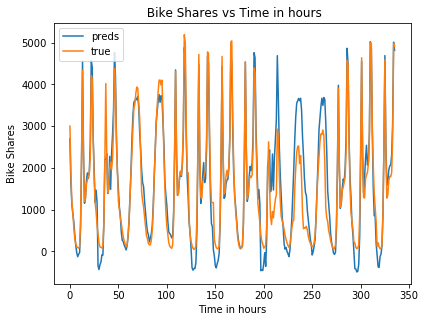

In [25]:
forthnightPred:336#SARIMApred;
forthnightTrue:336#yTestSales;
.util.plotPredTrue[forthnightPred;forthnightTrue]

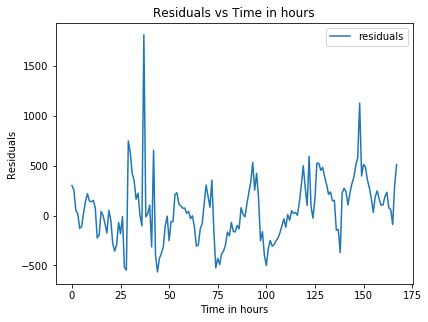

In [26]:
// 1 week of data at 1 hour intervals
idx:.ml.arange[0;168;1]
.util.plotResiduals[yTestSales idx;SARIMApred idx;idx]

**Summary**

* In comparison to the calculation of the RMSLE using with the AR and ARMA models, the SARIMA model performs significantly more reliably

| Model  | RMSLE   |
|:-------|---------|
| AR     | 0.93451 |
| ARMA   | 0.90168 |
| SARIMA | 0.77814 |
    
    
* Looking at the bike share predictions vs actual values it is clear that the addition of a weekly seasonal component to the model has provided a marked improvement on the models ability to capture the commute and weekly habits of those using the TFL bike sharing network.
* There are still hour to hour fluctuations in the predictive performance of the model, however the macroscopic trend of predictions is now being captured strongly.

---

## Feature Engineering for time series forecasting

Statistical models like those outlined above are extremely useful and fast when generating forecasting models. However they are often limited in their ability to discern non long term trends or to take into account the significance of the relationship between an exogenous variable and the forecasting target.

To allow traditional machine learning models such as Random Forest classifiers and Neural networks to be utilised a number of feature extraction techniques are provided within the toolkit.

| Function               | Purpose  |
|:-----------------------|:--------|
|`.ml.ts.laggedFeatures` | For a list of specified historical lags, add the value of a specified feature at row `k-lag` as a column to the dataset |
|`.ml.ts.windowFeatures` | For a set of features, unary functions and historical lagged windows apply a rolling window function over historical values and add the function return as a column.

When deciding what lagged and window lengths to use, it is worth noting that the larger the value that you use, the less data that is available for training. For example, if a lagged period of `N` is chosen, then the first `N` rows must will have to be removed as the the features generated from these are null due to insufficient data.

## Lagged and windowed features for prediction of TFL bike shares

The following feature extraction steps are taken to generate a dataset appropriate to allow for the use of a Random Forest Classifier to predict the future value of a time series

1. Generate a set of lagged features based on target variable to be calculated (```bikeSales`cnt```). The following are the calculated lags
    1. Two hours
    2. One day
    3. One week
2. Generate a set of rolling window features calculating the following features, `min`, `max`, `avg` and `dev` over the following lags
    1. Two hours
    2. One day
    4. One week
3. Split the data into a training and testing set with 80% in training and 20% in testing following feature extraction.
4. Fit a vanilla Random Forest Regressor to the training set and predict using the testing data.

### Generate Lagged Features

In [27]:
featureCol  :enlist`cnt        / columns from which lagged features are to be extracted
laggedLength:2 24 168          / list of lags to generate as features
5#laggedTab:.ml.ts.laggedFeatures[bikeSales;enlist`cnt;2 24 168]

// Show the new lagged columns created
5#reverse each laggedTab

cnt t1  t2  hum  wind_speed weather_code season timestamp_dayOfWeek timestamp..
-----------------------------------------------------------------------------..
182 3   2   93   6          3            3      1                   2015     ..
138 3   2.5 93   5          1            3      1                   2015     ..
134 2.5 2.5 96.5 0          1            3      1                   2015     ..
72  2   2   100  0          1            3      1                   2015     ..
47  2   0   93   6.5        1            3      1                   2015     ..


cnt_xprev_168 cnt_xprev_24 cnt_xprev_2 timestamp_hour timestamp_weekday times..
-----------------------------------------------------------------------------..
                                       0              0                 1    ..
                                       1              0                 1    ..
                           182         2              0                 1    ..
                           138         3              0                 1    ..
                           134         4              0                 1    ..


**Note:**

The generation of lagged features up to a maximum of one week generates null data in the first 168 rows (1 week in hours). As such before passing this data to a machine learning model the first 168 rows should be 'dropped' from the dataset

### Generate Windowed Features

In [28]:
// Create the windowed features
featureCol  :enlist`cnt        / columns from which windowed features are to be extracted
functionList:`min`max`avg`dev  / symbol list denoting the functions to be applied on windows
windowLength:2 24 168          / list of windows over which to apply feature extraction

5#windowLagTab:.ml.ts.windowFeatures[laggedTab;featureCol;functionList;windowLength]

// Show the new windowed columns created
5#reverse each windowLagTab

cnt t1  t2   hum  wind_speed weather_code season timestamp_dayOfWeek timestam..
-----------------------------------------------------------------------------..
360 4.5 0.5  72.5 22         1            3      1                   2015    ..
255 4   -0.5 75   22         1            3      1                   2015    ..
198 4   -0.5 75   23         1            3      1                   2015    ..
135 4   -1   75   27         2            3      1                   2015    ..
74  4   -1   72.5 28         1            3      1                   2015    ..


dev_168_cnt dev_24_cnt dev_2_cnt avg_168_cnt avg_24_cnt avg_2_cnt max_168_cnt..
-----------------------------------------------------------------------------..
772.6513    451.7794   0.5       751.6429    612.875    334.5     3618       ..
771.9912    452.476    13        752.7024    611.5417   347       3618       ..
771.489     453.1745   52.5      753.3988    610.625    307.5     3618       ..
771.1988    452.8291   28.5      753.7798    611        226.5     3618       ..
770.8824    453.6013   31.5      754.1548    610.25     166.5     3618       ..


**Note:**

Unlike in the generation of lagged features which do not remove the maximum number of rows from which the features are generated, in the case of the windowed features the `max[lag]` rows of the dataset are removed.

### Split dataset into training and testing set

In [29]:
// Retrieve the target dataset and remove from features for prediction to avoid leakage
targetData :exec cnt from windowLagTab
featureData:delete cnt from windowLagTab
tts:.util.ttsTimeSeries[featureData;targetData;0.2]

xTrainFeat:flip value flip tts`xtrain / Generate matrix representation of features
yTrainFeat:tts`ytrain
xTestFeat :flip value flip tts`xtest  / Generate matrix representation of features
yTestFeat :tts`ytest

-1!"There is ",string[count xTrainFeat]," data points in the training set"
-1!"There is ",string[count xTestFeat]," data points in the testing set"

"There is 13900 data points in the training set"


"There is 3476 data points in the testing set"


**Generate and fit a Random Forest Regressor**

In [30]:
// Load in an sklearn Random Forest Regressor 
randForest:.p.import[`sklearn.ensemble]`:RandomForestRegressor; / load model from sklearn
randForestModel:randForest[`random_state pykw 0];               / apply user defined hyperparameters

randForestModel[`:fit][xTrainFeat;yTrainFeat];                  / fit the model on training data

**Predicting future values using the Random Forest Regressor**

In [31]:
5#RandomPred:randForestModel[`:predict][xTestFeat]`

72.52 139.94 685.03 2112.95 3593.51


**Analysis of results**

In [32]:
.util.rmsle[RandomPred;yTestFeat]

"The RMSLE is: 0.2601446"


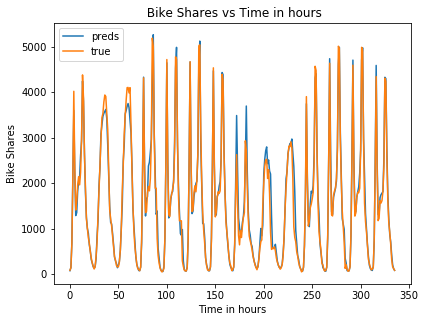

In [33]:
forthnightPred:336#RandomPred;
forthnightTrue:336#yTestFeat;
.util.plotPredTrue[forthnightPred;forthnightTrue]

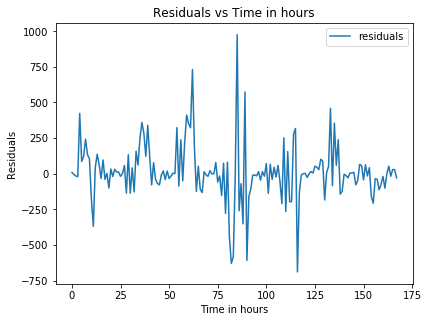

In [34]:
// 2 days of data at 1hour intervals
idx:.ml.arange[0;168;1]
.util.plotResiduals[yTestFeat idx;RandomPred idx;idx]

---

## Conclusions

* We have demonstrated a number of analysis techniques which can be used to determine potential issues and correlations within a time series dataset. These may make time series forecasting unsuitable in the case of non stationary data or can improve the model performance by looking at the autocorrelation and partial autocorrelations of the dataset.
* The addition of weekly seasonal components to the AR/ARMA models using a SARIMA model significantly improved the model performance in forecasting the bike shares.
* More traditional time series models can be used to forecast the behaviour of a time series using lagged and windowed features.

---